In [330]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [331]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('../data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [332]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [333]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

In [334]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:


In [335]:
ethnicity_freebase_ids = pd.read_csv('../handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [336]:
major_ethnicities = pd.read_csv('../handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [337]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)

In [338]:
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [339]:
characters.head(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity_label,major_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,Black
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN,NaN


The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [340]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

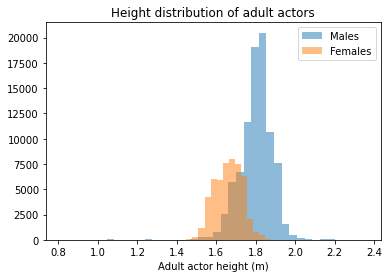

In [341]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

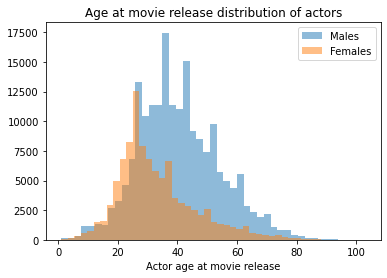

In [342]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

In [343]:
characters_male

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity_label,major_ethnicity
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans,Black
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN,NaN
7,975900,/m/03vyhn,2001-08-24,Big Daddy Mars,NaN,M,NaN,NaN,Richard Cetrone,NaN,/m/0bgchsy,/m/0bgcht0,/m/0bgcht7,NaN,NaN
8,975900,/m/03vyhn,2001-08-24,Michael Descanso,1971-03-20,M,1.892,NaN,Liam Waite,30.0,/m/03jqhb0,/m/0bgchs4,/m/0ks8b0,NaN,NaN
9,975900,/m/03vyhn,2001-08-24,Uno,NaN,M,NaN,NaN,Duane Davis,NaN,/m/0bgchtj,/m/0bgchtm,/m/03nrwdy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453616,913762,/m/03pcrp,1992-05-21,Additional Voices,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr405f,/m/0kr405k,/m/0gn4bz,NaN,NaN
453617,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz,NaN,NaN
453619,913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h,NaN,NaN
453621,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN,NaN


The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

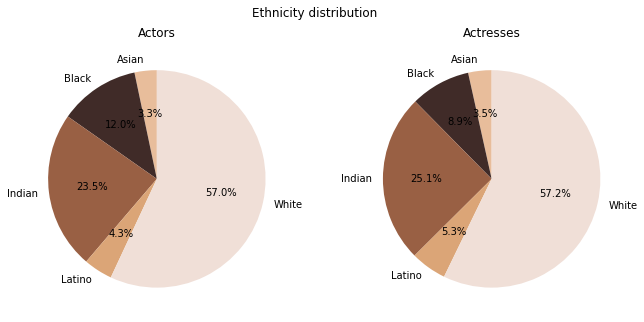

In [346]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

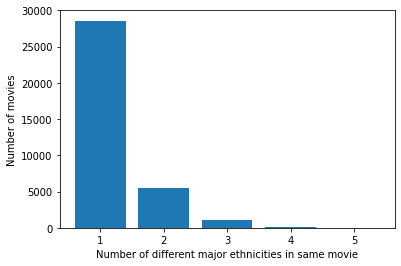

In [347]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities in same movie')
    plt.ylabel('Number of movies')
plot_different_ethnicities_per_movie(characters)

Since now, we have been working using all the characters in the dataset, even if the same actor played more than one. Now, let's focus on actors instead of characters to figure out the success associated to the professional. First we create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`

In [348]:
actors = characters[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity']]
actors = actors.dropna(subset=['freebase_actor_id'])
actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors.drop('freebase_movie_id', axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)
actors.head(5)


,freebase_actor_id,actor_name,actor_gender,actor_height_meters,ethnicity_label,major_ethnicity,num_movies
0,/m/03wcfv7,Wanda De Jesus,F,1.620,NaN,NaN,8
1,/m/0346l4,Natasha Henstridge,F,1.780,unknown,NaN,23
2,/m/01vw26l,Ice Cube,M,1.727,African Americans,Black,33
3,/m/034hyc,Jason Statham,M,1.750,NaN,NaN,31
4,/m/01y9xg,Clea DuVall,F,1.650,NaN,NaN,31


Again, let's split actors in genders

In [350]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [349]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

In [359]:
MIN_NUM_MOVIES_DEMANDED_ACTOR = 15
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)

This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

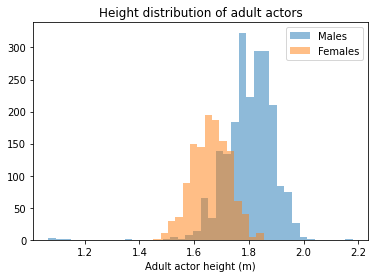

In [360]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

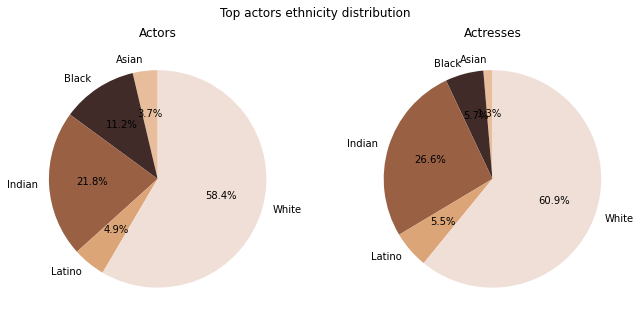

In [361]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                 demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions